<a href="https://colab.research.google.com/github/RGivisiez/Adv_ML/blob/clean/XGboost_and_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Importing

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from itertools import product

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
path = '/content/gdrive/My Drive/Colab Notebooks/Kaggle Data'

# Loading data

In [0]:
train = pd.read_csv(path + '/sales_train.csv.gz')
test = pd.read_csv(path + '/test.csv.gz')
items = pd.read_csv(path + '/items.csv')
items_cat = pd.read_csv(path + '/item_categories.csv')
shops = pd.read_csv(path + '/shops.csv')

print('Treino \n', train.head(), '\n')
print('Itens \n', items.head(), '\n')
print('Itens Cat \n', items_cat.head(), '\n')
print('Shops \n', shops.head(), '\n')

Treino 
          date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0 

Itens 
                                            item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40   

Itens Cat 
 

In [0]:
print('Teste \n', test.tail() )

Teste 
             ID  shop_id  item_id
214195  214195       45    18454
214196  214196       45    16188
214197  214197       45    15757
214198  214198       45    19648
214199  214199       45      969


# Creating new features

In [0]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops.drop(['shop_name', 'city'], axis='columns', inplace=True)
shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [0]:
items_cat['split'] = items_cat['item_category_name'].str.split('-')
items_cat['type'] = items_cat['split'].map(lambda x: x[0].strip())
items_cat['type_code'] = LabelEncoder().fit_transform(items_cat['type'])

items_cat['subtype'] = items_cat['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
items_cat['subtype_code'] = LabelEncoder().fit_transform(items_cat['subtype'])

items_cat.drop(['item_category_name', 'split', 'type', 'subtype'], axis='columns', inplace=True)
items_cat.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


In [0]:
items.drop(['item_name'], axis=1, inplace=True)
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [0]:
train.drop(['date'], axis='columns', inplace=True)
train.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,59,22154,999.00,1.0
1,0,25,2552,899.00,1.0
2,0,25,2552,899.00,-1.0
3,0,25,2554,1709.05,1.0
4,0,25,2555,1099.00,1.0


In [0]:
train_full = pd.merge(train, shops, on='shop_id', how='left')
train_full = pd.merge(train_full, items, on='item_id', how='left')
train_full = pd.merge(train_full, items_cat, on='item_category_id', how='left')
train_full.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,city_code,item_category_id,type_code,subtype_code
0,0,59,22154,999.00,1.0,30,37,11,1
1,0,25,2552,899.00,1.0,13,58,13,27
2,0,25,2552,899.00,-1.0,13,58,13,27
3,0,25,2554,1709.05,1.0,13,58,13,27
4,0,25,2555,1099.00,1.0,13,56,13,3


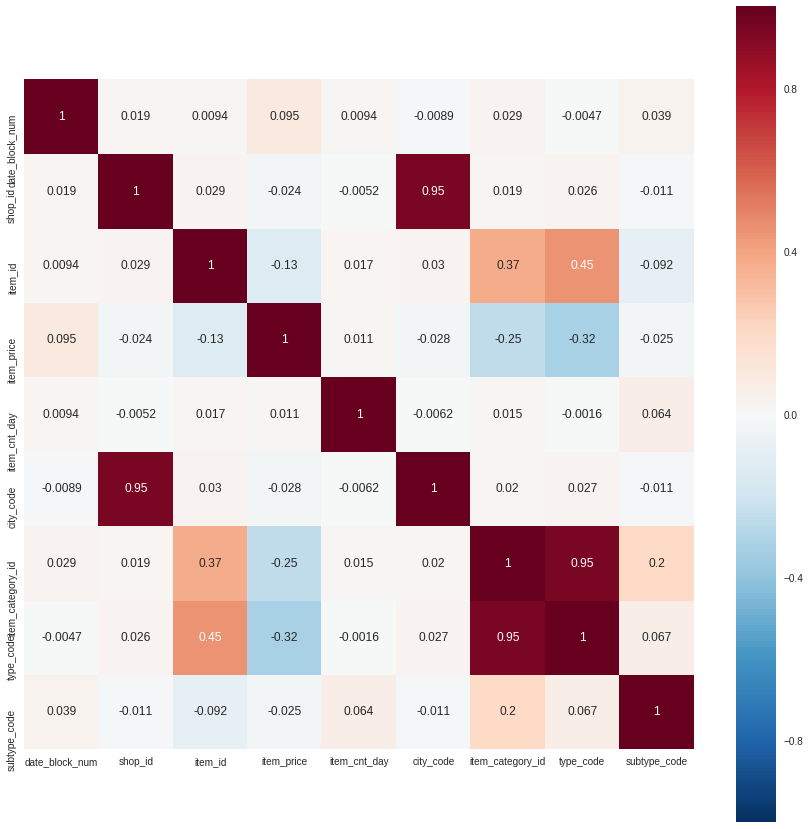

In [0]:
# Liner correlation between features.
correlation = train_full.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation, vmax=1, square=True,annot=True)
plt.show()

In [0]:
print('Test:')
print('- Número de itens únicos:', test['item_id'].nunique())
print('- Número de shoppings únicos:', test['shop_id'].nunique())
print('\n Train_full:')
print('- Número de itens únicos:', train_full['item_id'].nunique())
print('- Número de shoppings únicos:', train_full['shop_id'].nunique())

Test:
- Número de itens únicos: 5100
- Número de shoppings únicos: 42

 Train_full:
- Número de itens únicos: 21807
- Número de shoppings únicos: 60


In [0]:
train_full.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,city_code,item_category_id,type_code,subtype_code
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,1.617069e+01,4.000138e+01,9.872360e+00,2.096082e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,7.554980e+00,1.710076e+01,3.499719e+00,2.080453e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,1.300000e+01,2.800000e+01,8.000000e+00,4.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,1.300000e+01,4.000000e+01,1.100000e+01,1.100000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,2.300000e+01,5.500000e+01,1.300000e+01,4.100000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,3.000000e+01,8.300000e+01,1.900000e+01,6.400000e+01


In [0]:
test.describe()

,ID,shop_id,item_id
count,214200.000000,214200.000000,214200.000000
mean,107099.500000,31.642857,11019.398627
std,61834.358168,17.561933,6252.644590
min,0.000000,2.000000,30.000000
25%,53549.750000,16.000000,5381.500000
50%,107099.500000,34.500000,11203.000000
75%,160649.250000,47.000000,16071.500000
max,214199.000000,59.000000,22167.000000


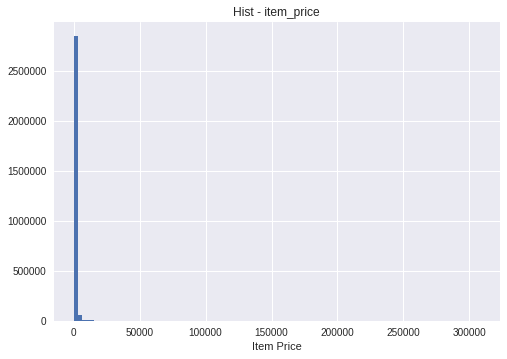

In [0]:
plt.hist(train_full['item_price'], bins = 100)
plt.title('Hist - item_price')
plt.xlabel('Item Price')
plt.show()

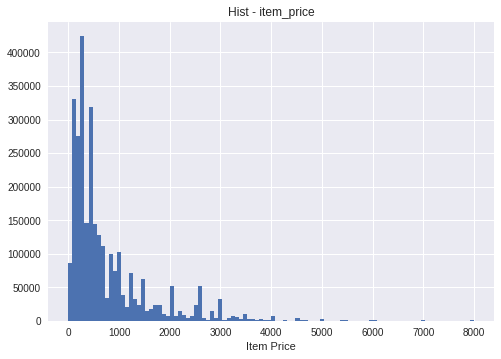

In [0]:
plt.hist(train_full['item_price'][train_full.item_price < 8000], bins = 100)
plt.title('Hist - item_price')
plt.xlabel('Item Price')
plt.show()

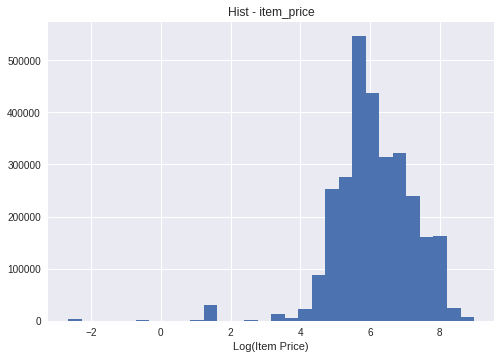

In [0]:
x = train_full['item_price'][train_full.item_price < 8000].values
x = np.log(np.abs(x))
plt.hist(x, bins = 30)
plt.title('Hist - item_price')
plt.xlabel('Log(Item Price)')
plt.show()

In [0]:
train_full = train_full[train_full.item_price < 100000]
train = train[train.item_price < 100000]

In [0]:
train_full = train_full[train_full.item_cnt_day < 1001]
train = train[train.item_cnt_day < 1001]

In [0]:
train_full.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,city_code,item_category_id,type_code,subtype_code
count,2.935847e+06,2.935847e+06,2.935847e+06,2.935847e+06,2.935847e+06,2.935847e+06,2.935847e+06,2.935847e+06,2.935847e+06
mean,1.456991e+01,3.300174e+01,1.019723e+04,8.907489e+02,1.241903e+00,1.617069e+01,4.000138e+01,9.872360e+00,2.096081e+01
std,9.422985e+00,1.622697e+01,6.324299e+03,1.720490e+03,2.292963e+00,7.554978e+00,1.710074e+01,3.499717e+00,2.080453e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,1.300000e+01,2.800000e+01,8.000000e+00,4.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,1.300000e+01,4.000000e+01,1.100000e+01,1.100000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,2.300000e+01,5.500000e+01,1.300000e+01,4.100000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,5.920000e+04,1.000000e+03,3.000000e+01,8.300000e+01,1.900000e+01,6.400000e+01


In [0]:
# Idk with this is true
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

# Months features

In [0]:
n_months = train['date_block_num'].nunique()
aux = []
for i in range(n_months):
    df = train[train.date_block_num == i]
    shop_uniq, item_uniq = df.shop_id.unique(), df.item_id.unique()

    a = list(product([i], shop_uniq, item_uniq))
    a = np.array(a)
    aux.append(a)
aux = pd.DataFrame(np.vstack(aux), columns=['date_block_num', 'shop_id', 'item_id'])
aux.sort_values(['date_block_num', 'shop_id', 'item_id'], inplace=True)

In [0]:
df_month = train.groupby(by=['date_block_num', 'shop_id', 'item_id'], axis='index').sum()
df_month.rename(columns={'item_cnt_day':'item_cnt_month'}, inplace=True)
df_month.reset_index(inplace=True)
df_month.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_month
0,0,2,27,2499.0,1.0
1,0,2,33,499.0,1.0
2,0,2,317,299.0,1.0
3,0,2,438,299.0,1.0
4,0,2,471,798.0,2.0


In [0]:
df_month['revenue'] = df_month['item_cnt_month'] * df_month['item_price']

In [0]:
df_month.rename(columns={'item_price':'item_price_month', 'revenue':'revenue_month'}, inplace=True)
df_month.head()

,date_block_num,shop_id,item_id,item_price_month,item_cnt_month,revenue_month
0,0,2,27,2499.0,1.0,2499.0
1,0,2,33,499.0,1.0,499.0
2,0,2,317,299.0,1.0,299.0
3,0,2,438,299.0,1.0,299.0
4,0,2,471,798.0,2.0,1596.0


In [0]:
df_month = pd.merge(aux, df_month, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)
del aux

In [0]:
df_month['item_cnt_month'] = df_month['item_cnt_month'].clip(0, 20)

In [0]:
test['date_block_num'] = 34
test.drop(['ID'], axis='columns', inplace=True)
test.head()

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [0]:
df_month = pd.concat([df_month, test], ignore_index=True, keys=['date_block_num', 'shop_id', 'item_id']).fillna(0)
df_month.tail()

,date_block_num,item_cnt_month,item_id,item_price_month,revenue_month,shop_id
11127999,34,0.0,18454,0.0,0.0,45
11128000,34,0.0,16188,0.0,0.0,45
11128001,34,0.0,15757,0.0,0.0,45
11128002,34,0.0,19648,0.0,0.0,45
11128003,34,0.0,969,0.0,0.0,45


In [0]:
df_month.describe()

,date_block_num,item_cnt_month,item_id,item_price_month,revenue_month,shop_id
count,1.112800e+07,1.112800e+07,1.112800e+07,1.112800e+07,1.112800e+07,1.112800e+07
mean,1.533960e+01,2.925003e-01,1.130371e+04,2.350019e+02,1.772792e+03,3.138372e+01
std,9.760412e+00,1.211247e+00,6.210934e+03,2.240315e+03,9.541417e+04,1.730666e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.351480e+05,2.000000e+00
25%,7.000000e+00,0.000000e+00,5.947000e+03,0.000000e+00,0.000000e+00,1.600000e+01
50%,1.500000e+01,0.000000e+00,1.138800e+04,0.000000e+00,0.000000e+00,3.100000e+01
75%,2.300000e+01,0.000000e+00,1.659200e+04,0.000000e+00,0.000000e+00,4.700000e+01
max,3.400000e+01,2.000000e+01,2.216900e+04,6.719300e+05,1.366834e+08,5.900000e+01


In [0]:
df_month = pd.merge(df_month, shops, on=['shop_id'], how='left')
df_month = pd.merge(df_month, items, on=['item_id'], how='left')
df_month = pd.merge(df_month, items_cat, on=['item_category_id'], how='left')

In [0]:
df_month['date_block_num'] = df_month['date_block_num'].astype('int8')
df_month['shop_id'] = df_month['shop_id'].astype('int8')
df_month['item_id'] = df_month['item_id'].astype('int8')
df_month['item_price_month'] = df_month['item_price_month'].astype('float32')
df_month['item_cnt_month'] = df_month['item_cnt_month'].astype('int8')
df_month['item_category_id'] = df_month['item_category_id'].astype('int8')
df_month['revenue_month'] = df_month['revenue_month'].astype('float32')
df_month['city_code'] = df_month['city_code'].astype('int8')
df_month['type_code'] = df_month['type_code'].astype('int8')
df_month['subtype_code'] = df_month['subtype_code'].astype('int8')

In [0]:
df_month.head()

,date_block_num,item_cnt_month,item_id,item_price_month,revenue_month,shop_id,city_code,item_category_id,type_code,subtype_code
0,0,0,19,0.0,0.0,2,0,40,11,4
1,0,1,27,2499.0,2499.0,2,0,19,5,10
2,0,0,28,0.0,0.0,2,0,30,8,55
3,0,0,29,0.0,0.0,2,0,23,5,16
4,0,0,32,0.0,0.0,2,0,40,11,4


In [0]:
df_month.describe()

,date_block_num,item_cnt_month,item_id,item_price_month,revenue_month,shop_id,city_code,item_category_id,type_code,subtype_code
count,1.112800e+07,1.112800e+07,1.112800e+07,1.112800e+07,1.112800e+07,1.112800e+07,1.112800e+07,1.112800e+07,1.112800e+07,1.112800e+07
mean,1.533960e+01,2.925003e-01,-9.617815e-01,2.350121e+02,1.766464e+03,3.138372e+01,1.530356e+01,4.494398e+01,1.107023e+01,1.810709e+01
std,9.760412e+00,1.211247e+00,7.383618e+01,2.228348e+03,9.538228e+04,1.730666e+01,8.018806e+00,1.514000e+01,2.854886e+00,2.015452e+01
min,0.000000e+00,0.000000e+00,-1.280000e+02,0.000000e+00,-1.351480e+05,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.000000e+00,0.000000e+00,-6.500000e+01,0.000000e+00,0.000000e+00,1.600000e+01,1.000000e+01,3.700000e+01,1.100000e+01,2.000000e+00
50%,1.500000e+01,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,3.100000e+01,1.300000e+01,4.000000e+01,1.100000e+01,4.000000e+00
75%,2.300000e+01,0.000000e+00,6.300000e+01,0.000000e+00,0.000000e+00,4.700000e+01,2.200000e+01,5.500000e+01,1.300000e+01,3.200000e+01
max,3.400000e+01,2.000000e+01,1.270000e+02,6.719300e+05,1.366834e+08,5.900000e+01,3.000000e+01,8.300000e+01,1.900000e+01,6.400000e+01


# PCA

-https://www.kaggle.com/arthurtok/interactive-intro-to-dimensionality-reduction
- http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html

In [0]:
col = ['city_code', 'shop_id', 'item_category_id', 'type_code', 'item_id']

In [0]:
scaler = StandardScaler().fit(df_month[col]) # salva a média e std de cada coluna, para poder ser aplicado no set de treino.
X = scaler.transform(df_month[col])
print('\nMean:', scaler.mean_, '\n\nStd:', scaler.scale_)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)



Mean: [15.30356271 31.38371949 44.94398375 11.07022616 -0.96178147] 

Std: [ 8.01880568 17.30665644 15.13999503  2.85488562 73.83617625]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int8 were all converted to float64 by StandardScaler.
  


In [0]:
#@title Dataframe centrado em zero com variância 1.
pd.DataFrame(X, columns=col).describe()

,city_code,shop_id,item_category_id,type_code,item_id
count,1.112800e+07,1.112800e+07,1.112800e+07,1.112800e+07,1.112800e+07
mean,1.269627e-12,-6.552500e-13,3.709326e-14,-7.766204e-13,1.421452e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.908459e+00,-1.697828e+00,-2.968560e+00,-3.877643e+00,-1.720542e+00
25%,-6.613906e-01,-8.888903e-01,-5.247019e-01,-2.459859e-02,-8.673014e-01
50%,-2.872700e-01,-2.217179e-02,-3.265512e-01,-2.459859e-02,-5.176126e-04
75%,8.350916e-01,9.023280e-01,6.642021e-01,6.759549e-01,8.662662e-01
max,1.832746e+00,1.595703e+00,2.513608e+00,2.777615e+00,1.733050e+00


In [0]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)

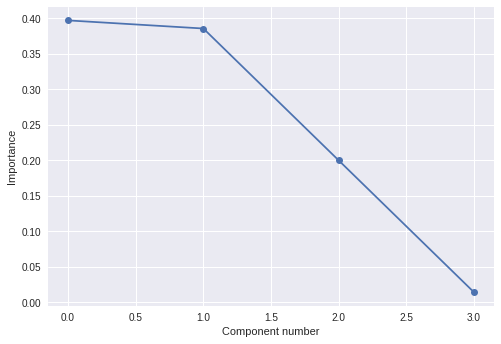

In [0]:
plt.plot(pca.explained_variance_ratio_, marker='o')
plt.ylabel('Importance')
plt.xlabel('Component number')
plt.show()

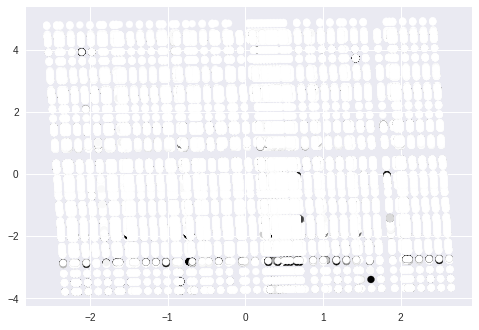

In [0]:
#plt.scatter(principalDf[0], principalDf[1])

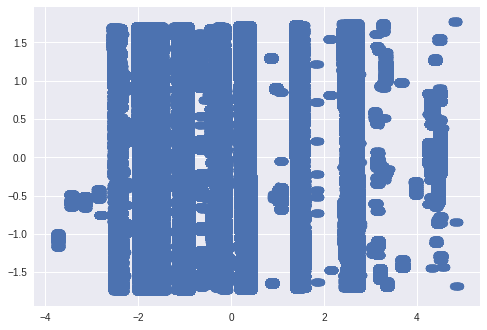

In [0]:
plt.scatter(principalDf[1], principalDf[2])

# Lagged features

In [0]:
df_lag3 = df_month[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'revenue_month']].copy()
df_lag3.rename(columns={'item_cnt_month':'lag3_item_cnt_month', 'revenue_month':'lag3_revenue_month'}, inplace=True)
df_lag3['date_block_num'] += 3
df_month = pd.merge(df_month, df_lag3, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)
del df_lag3

In [0]:
df_lag6 = df_month[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'revenue_month']].copy()
df_lag6.rename(columns={'item_cnt_month':'lag6_item_cnt_month', 'revenue_month':'lag6_revenue_month'}, inplace=True)
df_lag6['date_block_num'] += 6
df_month = pd.merge(df_month, df_lag6, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)
del df_lag6

In [0]:
df_lag9 = df_month[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'revenue_month']].copy()
df_lag9.rename(columns={'item_cnt_month':'lag9_item_cnt_month', 'revenue_month':'lag9_revenue_month'}, inplace=True)
df_lag9['date_block_num'] += 9
df_month = pd.merge(df_month, df_lag9, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)
del df_lag9

In [0]:
df_lag12 = df_month[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'revenue_month']].copy()
df_lag12.rename(columns={'item_cnt_month':'lag12_item_cnt_month', 'revenue_month':'lag12_revenue_month'}, inplace=True)
df_lag12['date_block_num'] += 12
df_month = pd.merge(df_month, df_lag12, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)
del df_lag12

In [0]:
#df_month['lag3_item_cnt_month'] = df_month['lag3_item_cnt_month'].astype('float16')
df_month['lag6_item_cnt_month'] = df_month['lag6_item_cnt_month'].astype('float16')
#df_month['lag9_item_cnt_month'] = df_month['lag9_item_cnt_month'].astype('float16')
#df_month['lag12_item_cnt_month'] = df_month['lag12_item_cnt_month'].astype('float16')

#df_month['lag3_revenue_month'] = df_month['lag3_revenue_month'].astype('float16')
df_month['lag6_revenue_month'] = df_month['lag6_revenue_month'].astype('float16')
#df_month['lag9_revenue_month'] = df_month['lag9_revenue_month'].astype('float16')
#df_month['lag12_revenue_month'] = df_month['lag12_revenue_month'].astype('float16')

In [0]:
df_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 12 columns):
date_block_num         int8
item_cnt_month         int8
item_id                int8
item_price_month       float16
revenue_month          float16
shop_id                int8
city_code              int8
item_category_id       int8
type_code              int8
subtype_code           int8
lag6_item_cnt_month    float16
lag6_revenue_month     float16
dtypes: float16(4), int8(8)
memory usage: 254.7 MB


In [0]:
df_month.head()

# XGboost

In [0]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=100,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3)

X_train = df_month[df_month.date_block_num < 33].drop(['item_cnt_month'], axis='columns')
Y_train = df_month[df_month.date_block_num < 33]['item_cnt_month']

X_valid = df_month[df_month.date_block_num == 33].drop(['item_cnt_month'], axis='columns')
Y_valid = df_month[df_month.date_block_num == 33]['item_cnt_month']

X_test = df_month[df_month.date_block_num == 34].drop(['item_cnt_month'], axis=1)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 5)

In [0]:
xgb.plot_importance(model, importance_type='weight')
plt.show()